# Gesture Recognition¶
 Problem Statement: Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

 The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a  specific command:

 Thumbs up: Increase the volume 
 Thumbs down: Decrease the volume 
 Left swipe: 'Jump' backward 10 seconds 
 Right swipe: 'Jump' forward 10 seconds
 Stop: Pause the movie 

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)


2024-04-08 11:34:46.084870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 11:34:46.085010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 11:34:46.410976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout,TimeDistributed, Flatten, BatchNormalization, Activation, LSTM, Conv3D,Conv2D,MaxPooling2D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


In [4]:
train_doc = np.random.permutation(open('/kaggle/input/dataset/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/dataset/Project_data/val.csv').readlines())
batch_size = 8 

# Data Preprocessing

In [5]:
total_frames = 30
num_frames = 15
classes = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [6]:
# Resize,crop and normalize the images
from skimage.transform import resize

def resize_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

In [7]:
from matplotlib import pyplot as plt

def show_resize_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

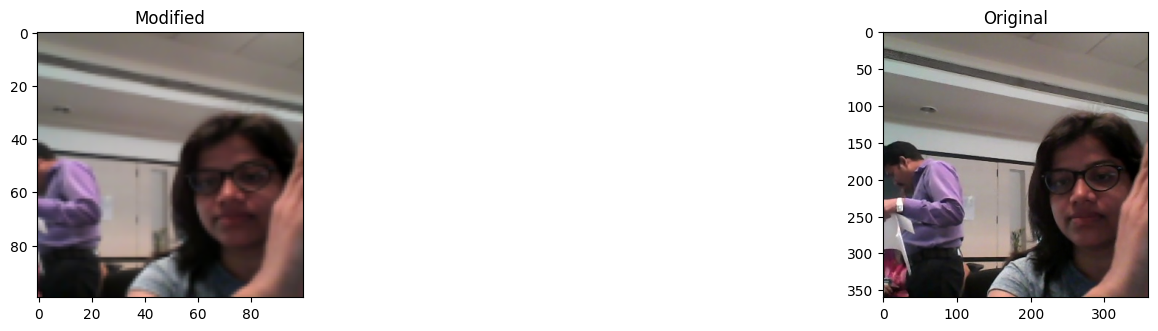

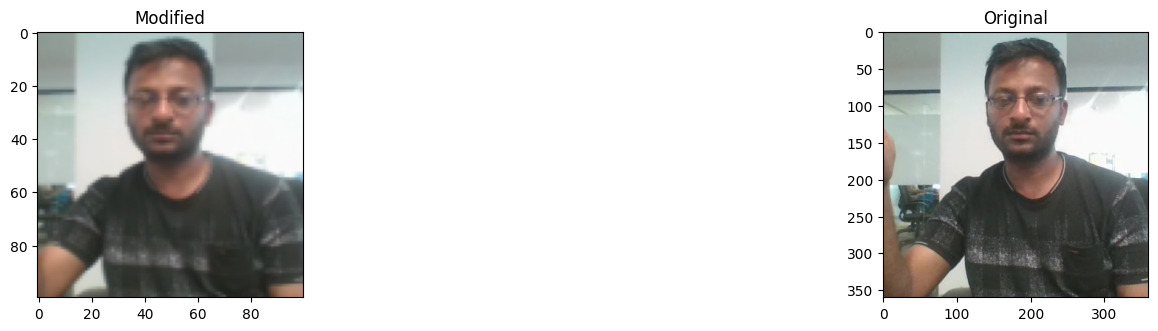

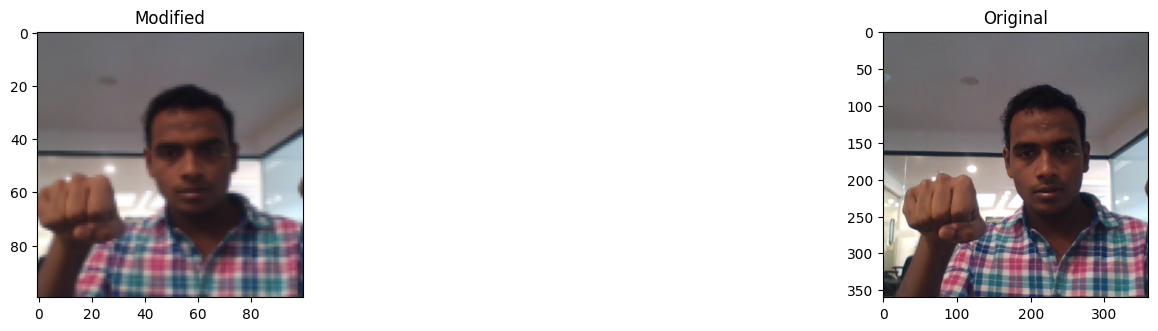

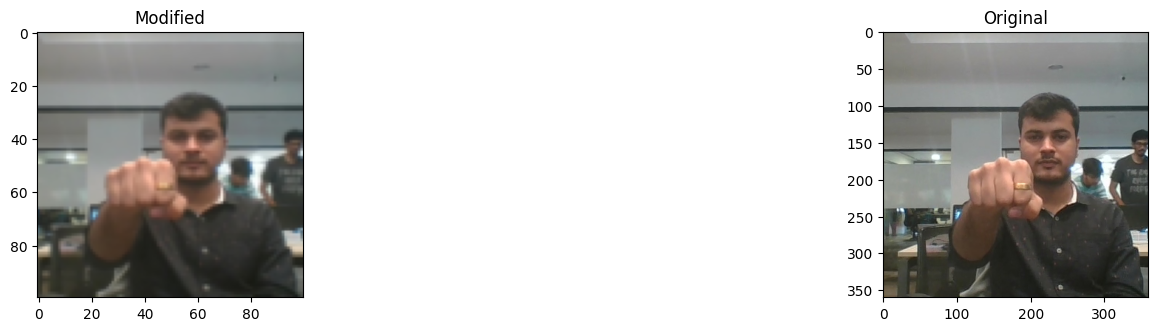

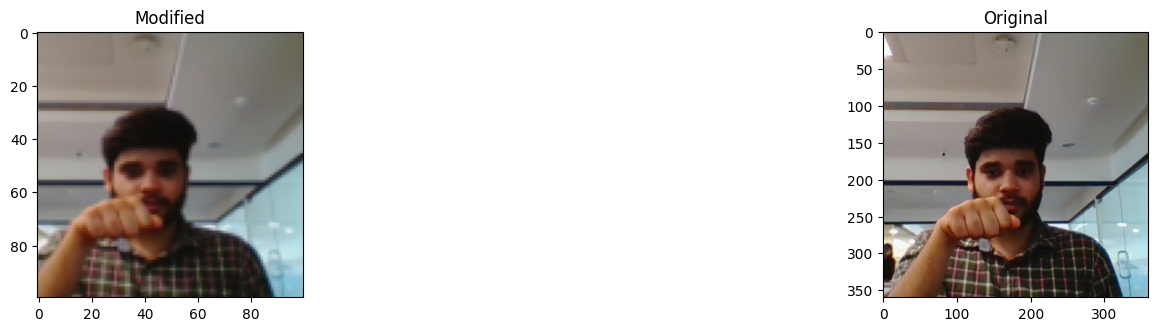

In [8]:
paths = ["/kaggle/input/dataset/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png",
        "/kaggle/input/dataset/Project_data/train/WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_38_17_Pro_00031.png",
        "/kaggle/input/dataset/Project_data/train/WIN_20180907_15_38_35_Pro_Thumbs Down_new/WIN_20180907_15_38_35_Pro_00012.png",
        "/kaggle/input/dataset/Project_data/train/WIN_20180907_15_39_54_Pro_Thumbs Up_new/WIN_20180907_15_39_54_Pro_00013.png",
        "/kaggle/input/dataset/Project_data/train/WIN_20180907_15_43_40_Pro_Stop Gesture_new/WIN_20180907_15_43_40_Pro_00009.png"]

show_resize_image(paths)


# Generator

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, classes)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/dataset/Project_data/train'
val_path = '/kaggle/input/dataset/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


# Model Building

# Sample Model :  Model 1

In [11]:

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(classes, activation='softmax'))

In [12]:
optimiser = optimizers.SGD(learning_rate= 0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 100, 100,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 100, 100,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 15, 100, 100,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 7, 50, 50, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 7, 50, 50, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 50, 50, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 50, 50, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 3, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 3, 25, 25, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 25, 25, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 25, 25, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 1, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317,669 (1.21 MB)

 Trainable params: 317,557 (1.21 MB)

 Non-trainable params: 112 (448.00 B)

None


In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 8
Epoch 1/25
 1/83 ━━━━━━━━━━━━━━━━━━━━ 15:47 12s/step - categorical_accuracy: 0.3750 - loss: 1.0849

I0000 00:00:1712576121.135021      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712576121.152912      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2238 - loss: 1.9884

W0000 00:00:1712576311.796271      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 8


W0000 00:00:1712576315.200136      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.61738, saving model to model_init_2024-04-0811_35_06.450272/model-00001-1.76613-0.21418-1.61738-0.20000.h5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - categorical_accuracy: 0.2237 - loss: 1.9857 - val_categorical_accuracy: 0.2000 - val_loss: 1.6174 - learning_rate: 0.0010
Epoch 2/25
 1/83 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.2857 - loss: 1.6105

W0000 00:00:1712576343.710664      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2091 - loss: 1.6025
Epoch 2: val_loss improved from 1.61738 to 1.60051, saving model to model_init_2024-04-0811_35_06.450272/model-00002-1.59909-0.23408-1.60051-0.21154.h5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - categorical_accuracy: 0.2094 - loss: 1.6025 - val_categorical_accuracy: 0.2115 - val_loss: 1.6005 - learning_rate: 0.0010
Epoch 3/25
22/83 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - categorical_accuracy: 0.2113 - loss: 1.6355 

W0000 00:00:1712576460.181737      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - categorical_accuracy: 0.2162 - loss: 1.6224
Epoch 3: val_loss did not improve from 1.60051
83/83 ━━━━━━━━━━━━━━━━━━━━ 71s 861ms/step - categorical_accuracy: 0.2163 - loss: 1.6222 - val_categorical_accuracy: 0.2500 - val_loss: 1.6204 - learning_rate: 0.0010
Epoch 4/25
77/83 ━━━━━━━━━━━━━━━━━━━━ 4s 758ms/step - categorical_accuracy: 0.2481 - loss: 1.5911

W0000 00:00:1712576565.718905      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - categorical_accuracy: 0.2486 - loss: 1.5924
Epoch 4: val_loss did not improve from 1.60051

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 753ms/step - categorical_accuracy: 0.2487 - loss: 1.5926 - val_categorical_accuracy: 0.2500 - val_loss: 1.6399 - learning_rate: 0.0010
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - categorical_accuracy: 0.2723 - loss: 1.6505
Epoch 5: val_loss improved from 1.60051 to 1.57115, saving model to model_init_2024-04-0811_35_06.450272/model-00005-1.59646-0.28916-1.57115-0.32692.h5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 439ms/step - categorical_accuracy: 0.2725 - loss: 1.6498 - val_categorical_accuracy: 0.3269 - val_loss: 1.5711 - learning_rate: 5.0000e-04
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - categorical_accuracy: 0.2448 - loss: 1.6025
Epoch 6: val_loss improved from 1.57115 to 1.55566, saving model to model_init_2024-04-0811_35_06.4

## Model Plot Function

In [17]:
from IPython.display import Markdown, display

def plot_model(model_plot):
#     display(Markdown("**Training Accuracy:** " + str(round(model_plot.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
#     display(Markdown("**Validation Accuracy:** " + str(round(model_plot.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))
    

    acc = model_plot.history['categorical_accuracy']
    val_acc = model_plot.history['val_categorical_accuracy']

    loss = model_plot.history['loss']
    val_loss = model_plot.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()



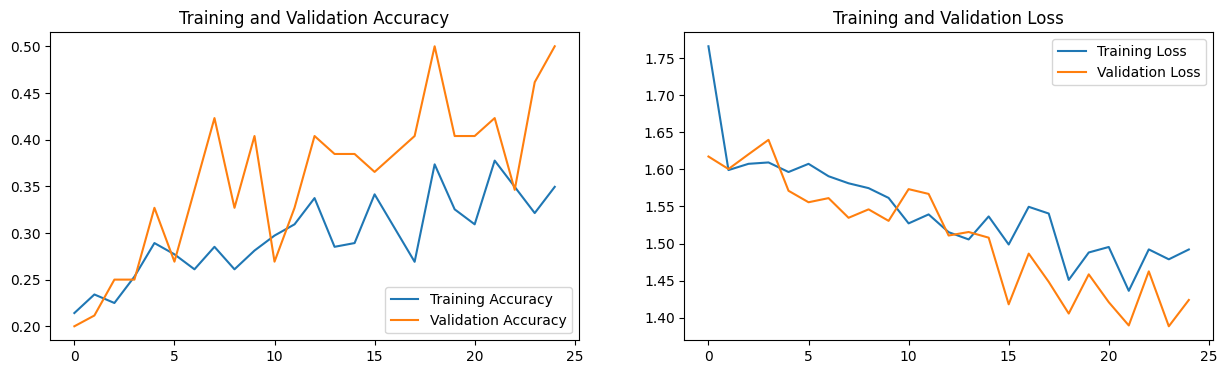

In [18]:
plot_model(model_plot)

# MODEL - 2

### We are reducing the size of the images from 100 to 50

In [19]:
total_frames = 30
num_frames = 15
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

In [20]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(classes, activation='softmax'))

In [21]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 15, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 15, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 7, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 7, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 3, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 3, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 8
Epoch 1/25
 1/83 ━━━━━━━━━━━━━━━━━━━━ 10:52 8s/step - categorical_accuracy: 0.5000 - loss: 1.6130

W0000 00:00:1712577424.603885      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2203 - loss: 2.0182

W0000 00:00:1712577521.072063      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 8


W0000 00:00:1712577523.072997      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.62660, saving model to model_exp2_2024-04-0811_35_06.450272/model-00001-1.80090-0.22021-1.62660-0.24000.h5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - categorical_accuracy: 0.2203 - loss: 2.0156 - val_categorical_accuracy: 0.2400 - val_loss: 1.6266 - learning_rate: 0.0010
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - categorical_accuracy: 0.2850 - loss: 1.5733
Epoch 2: val_loss improved from 1.62660 to 1.59080, saving model to model_exp2_2024-04-0811_35_06.450272/model-00002-1.60967-0.24613-1.59080-0.21154.h5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - categorical_accuracy: 0.2846 - loss: 1.5738 - val_categorical_accuracy: 0.2115 - val_loss: 1.5908 - learning_rate: 0.0010
Epoch 3/25
23/83 ━━━━━━━━━━━━━━━━━━━━ 54s 902ms/step - categorical_accuracy: 0.2041 - loss: 1.6057

W0000 00:00:1712577639.554371      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - categorical_accuracy: 0.2164 - loss: 1.6041
Epoch 3: val_loss did not improve from 1.59080
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 765ms/step - categorical_accuracy: 0.2166 - loss: 1.6041 - val_categorical_accuracy: 0.3077 - val_loss: 1.5928 - learning_rate: 0.0010
Epoch 4/25
78/83 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step - categorical_accuracy: 0.2526 - loss: 1.5963

W0000 00:00:1712577731.446695      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 4: val_loss improved from 1.59080 to 1.51503, saving model to model_exp2_2024-04-0811_35_06.450272/model-00004-1.60831-0.23785-1.51503-0.28846.h5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 633ms/step - categorical_accuracy: 0.2516 - loss: 1.5973 - val_categorical_accuracy: 0.2885 - val_loss: 1.5150 - learning_rate: 0.0010
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - categorical_accuracy: 0.2272 - loss: 1.5719
Epoch 5: val_loss did not improve from 1.51503
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 340ms/step - categorical_accuracy: 0.2271 - loss: 1.5719 - val_categorical_accuracy: 0.3077 - val_loss: 1.5675 - learning_rate: 0.0010
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - categorical_accuracy: 0.2831 - loss: 1.6036
Epoch 6: val_loss improved from 1.51503 to 1.50573, saving model to model_exp2_2024-04-0811_35_06.450272/model-00006-1.61878-0.29719-1.50573-0.40385.h5.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 413ms/step - categorical_accuracy: 0.2832 - loss: 1.6038 - val_categorical_ac

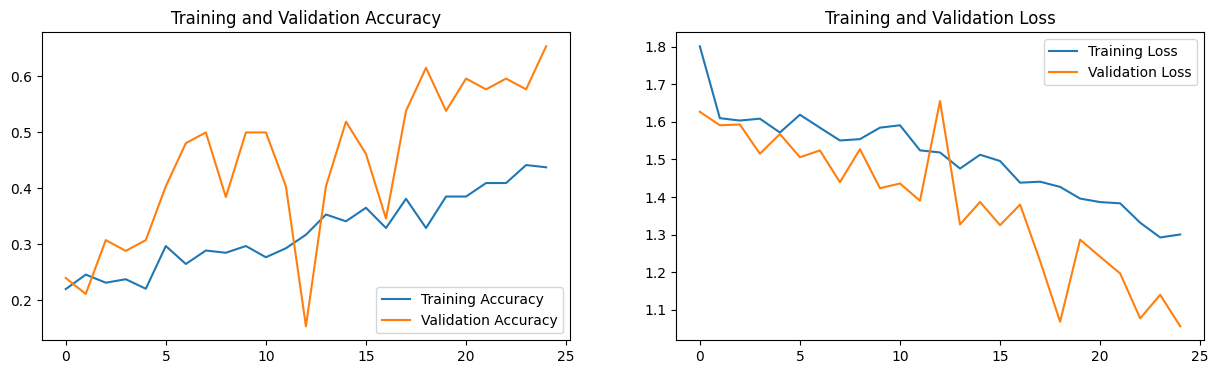

In [26]:
plot_model(model_plot)

# MODEL - 3   

### Now we change the optimizer from SGD to Adam & decreased the batch_size from 8 to 4

In [27]:
total_frames = 30
num_frames = 15
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25


In [28]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 15, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 15, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 7, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 7, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 7, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 3, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 3, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 3, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - categorical_accuracy: 0.1753 - loss: 2.2084

W0000 00:00:1712578534.734688      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.56349, saving model to model_exp3_2024-04-0811_35_06.450272/model-00001-1.90033-0.19155-1.56349-0.30000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 116s 646ms/step - categorical_accuracy: 0.1754 - loss: 2.2065 - val_categorical_accuracy: 0.3000 - val_loss: 1.5635 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - categorical_accuracy: 0.2801 - loss: 1.6162
Epoch 2: val_loss improved from 1.56349 to 1.52793, saving model to model_exp3_2024-04-0811_35_06.450272/model-00002-1.60843-0.25502-1.52793-0.28000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 80s 486ms/step - categorical_accuracy: 0.2799 - loss: 1.6162 - val_categorical_accuracy: 0.2800 - val_loss: 1.5279 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - categorical_accuracy: 0.2443 - loss: 1.5710
Epoch 3: val_loss improved from 1.52793 to 1.47683, saving model to mod

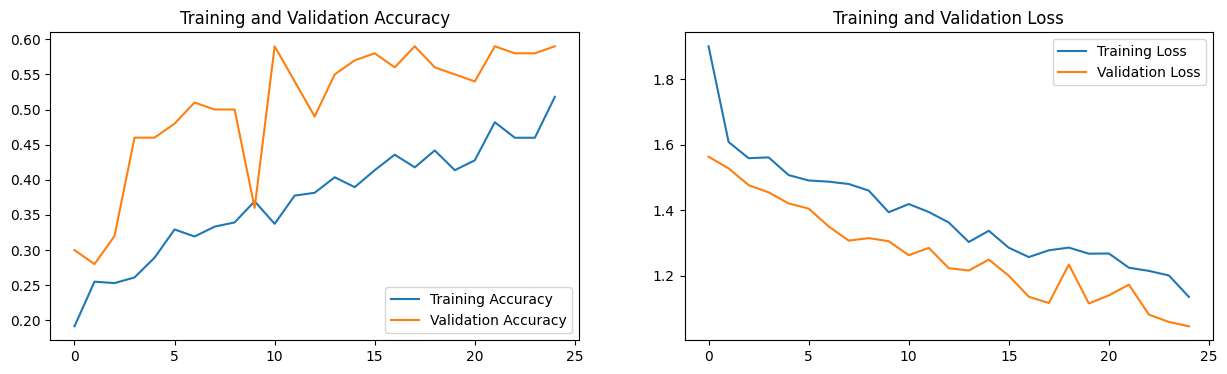

In [33]:
plot_model(model_plot)

# MODEL - 4  


###  We reduced the number of frames (num_frames) from 15 to 10 

In [34]:
total_frames = 30
num_frames = 10
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25


In [35]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 10, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 10, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 5, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 5, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 5, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 5, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 2, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 2, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - categorical_accuracy: 0.2167 - loss: 2.2168

W0000 00:00:1712580287.004007      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60913, saving model to model_exp4_2024-04-0811_35_06.450272/model-00001-1.85322-0.21719-1.60913-0.16000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 113s 637ms/step - categorical_accuracy: 0.2167 - loss: 2.2146 - val_categorical_accuracy: 0.1600 - val_loss: 1.6091 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - categorical_accuracy: 0.2413 - loss: 1.6127
Epoch 2: val_loss improved from 1.60913 to 1.60088, saving model to model_exp4_2024-04-0811_35_06.450272/model-00002-1.61132-0.23494-1.60088-0.24000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - categorical_accuracy: 0.2413 - loss: 1.6127 - val_categorical_accuracy: 0.2400 - val_loss: 1.6009 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - categorical_accuracy: 0.2378 - loss: 1.5987
Epoch 3: val_loss improved from 1.60088 to 1.57643, saving model to mod

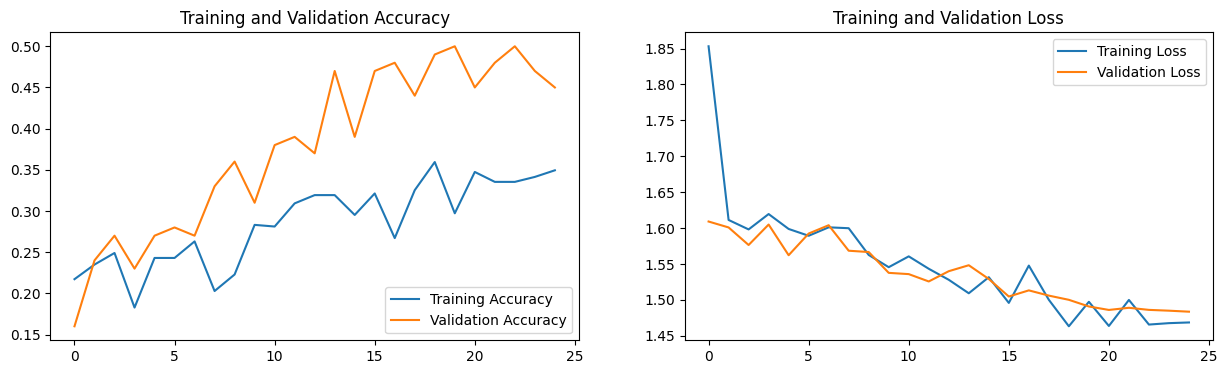

In [40]:
plot_model(model_plot)

# MODEL -5  

### Reducing the dropout rate from 0.5 to 0.25 

In [41]:
total_frames = 30
num_frames = 10
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [42]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 10, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 10, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 5, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 5, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 5, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 5, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 2, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 2, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 2, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [43]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [44]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - categorical_accuracy: 0.2058 - loss: 1.8311

W0000 00:00:1712581441.311762      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.51340, saving model to model_exp5_2024-04-0811_35_06.450272/model-00001-1.65001-0.26848-1.51340-0.26000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 79s 430ms/step - categorical_accuracy: 0.2062 - loss: 1.8300 - val_categorical_accuracy: 0.2600 - val_loss: 1.5134 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - categorical_accuracy: 0.3300 - loss: 1.4852
Epoch 2: val_loss improved from 1.51340 to 1.31686, saving model to model_exp5_2024-04-0811_35_06.450272/model-00002-1.48727-0.34337-1.31686-0.50000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - categorical_accuracy: 0.3301 - loss: 1.4852 - val_categorical_accuracy: 0.5000 - val_loss: 1.3169 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - categorical_accuracy: 0.3480 - loss: 1.4470
Epoch 3: val_loss did not improve from 1.31686
166/166 ━━━━━━━━━━━━━━━━━

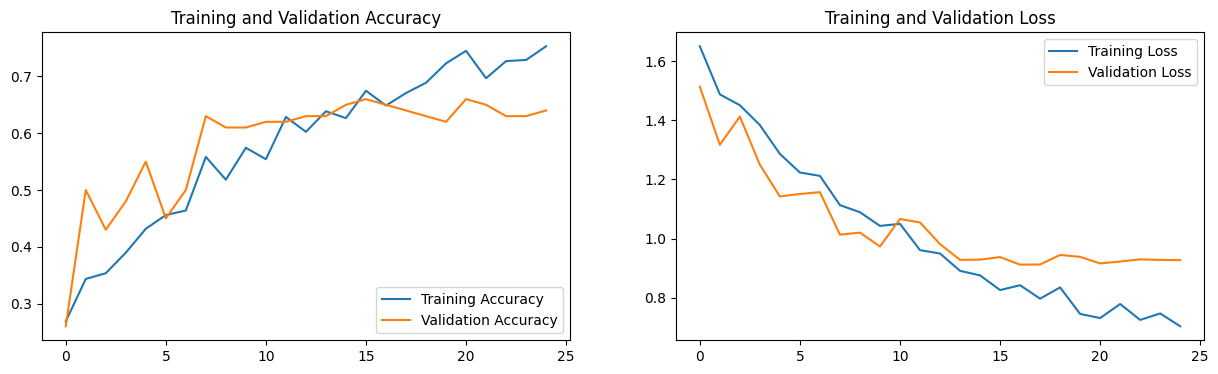

In [47]:
plot_model(model_plot)  

# MODEL - 6
### Now we increasing the number of epochs from 25 to 35

In [48]:
total_frames = 30
num_frames = 10
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [49]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_15 (Conv3D)              │ (None, 10, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 10, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 5, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 5, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 5, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 5, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 2, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_17 (Conv3D)              │ (None, 2, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 2, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [50]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [51]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [53]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - categorical_accuracy: 0.1718 - loss: 1.9596

W0000 00:00:1712583095.708611      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.49600, saving model to model_exp6_2024-04-0811_35_06.450272/model-00001-1.74687-0.22624-1.49600-0.26000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 87s 483ms/step - categorical_accuracy: 0.1721 - loss: 1.9583 - val_categorical_accuracy: 0.2600 - val_loss: 1.4960 - learning_rate: 2.0000e-04
Epoch 2/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - categorical_accuracy: 0.3333 - loss: 1.4949
Epoch 2: val_loss improved from 1.49600 to 1.44921, saving model to model_exp6_2024-04-0811_35_06.450272/model-00002-1.50932-0.30924-1.44921-0.32000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - categorical_accuracy: 0.3331 - loss: 1.4950 - val_categorical_accuracy: 0.3200 - val_loss: 1.4492 - learning_rate: 2.0000e-04
Epoch 3/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - categorical_accuracy: 0.3450 - loss: 1.4895
Epoch 3: val_loss improved from 1.44921 to 1.25592, saving model to mode

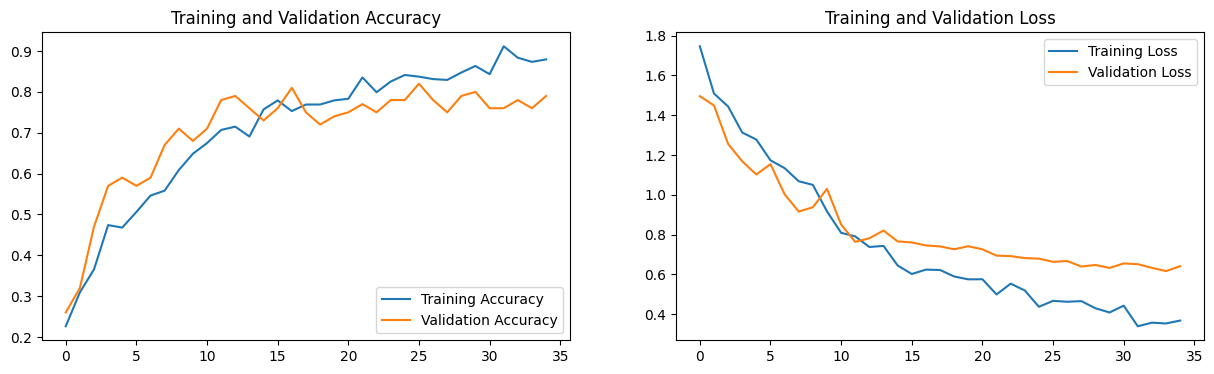

In [54]:
plot_model(model_plot)   

# Model 7  Using Model 5

### Increased the number of frames from 10 to 12 to check wheather the accuracy increased 

In [55]:
total_frames = 30
num_frames = 12 
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4 

num_epochs=25

In [56]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_18 (Conv3D)              │ (None, 10, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 10, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 5, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 5, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 5, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 5, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 2, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_20 (Conv3D)              │ (None, 2, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 2, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 2, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [57]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [58]:
model_name = 'model_exp5_1_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [60]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - categorical_accuracy: 0.2199 - loss: 1.7900

W0000 00:00:1712584787.257249      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.57180, saving model to model_exp5_1_2024-04-0811_35_06.450272/model-00001-1.65091-0.27602-1.57180-0.24000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 128s 719ms/step - categorical_accuracy: 0.2202 - loss: 1.7891 - val_categorical_accuracy: 0.2400 - val_loss: 1.5718 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - categorical_accuracy: 0.4123 - loss: 1.3916
Epoch 2: val_loss improved from 1.57180 to 1.22931, saving model to model_exp5_1_2024-04-0811_35_06.450272/model-00002-1.41800-0.39558-1.22931-0.48000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 63s 384ms/step - categorical_accuracy: 0.4122 - loss: 1.3917 - val_categorical_accuracy: 0.4800 - val_loss: 1.2293 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - categorical_accuracy: 0.4108 - loss: 1.4079
Epoch 3: val_loss improved from 1.22931 to 1.17893, saving model to

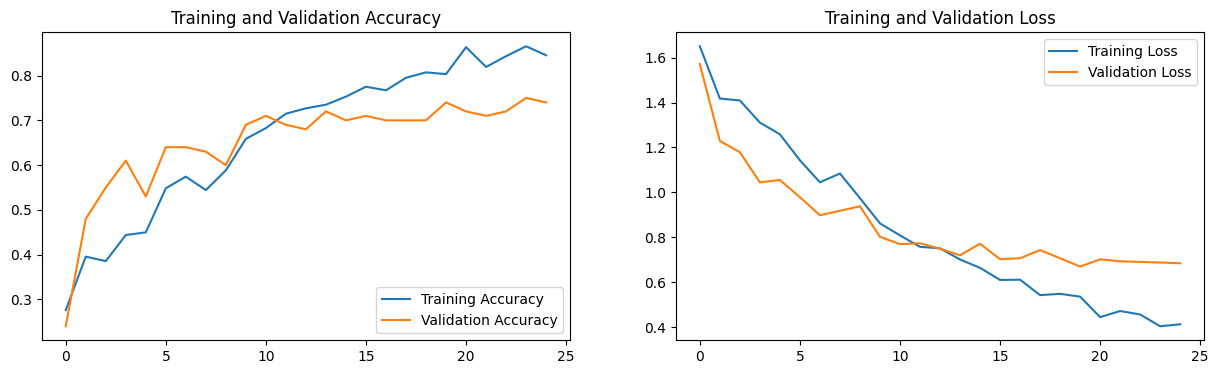

In [61]:
plot_model(model_plot)

# Model 8  Using Model 6

### Increased the number of frames from 10 to 12 & batch_size from 4 to 6,  to check wheather the accuracy increased 

In [64]:
total_frames = 30
num_frames = 12  
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 6   

num_epochs=35

In [65]:
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(classes, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_21 (Conv3D)              │ (None, 12, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 12, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 12, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_21 (MaxPooling3D) │ (None, 6, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_22 (Conv3D)              │ (None, 6, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 6, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 6, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_22 (MaxPooling3D) │ (None, 3, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_23 (Conv3D)              │ (None, 3, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 3, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 3, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_23 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,485 (376.89 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

None


In [66]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [67]:
model_name = 'model_exp6_1_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [68]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [69]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 6
Epoch 1/35
  1/111 ━━━━━━━━━━━━━━━━━━━━ 16:52 9s/step - categorical_accuracy: 0.1667 - loss: 2.0850

W0000 00:00:1712586548.483164      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - categorical_accuracy: 0.2082 - loss: 1.8467

W0000 00:00:1712586622.539592      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 6


W0000 00:00:1712586624.164706      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.68309, saving model to model_exp6_1_2024-04-0811_35_06.450272/model-00001-1.65608-0.28658-1.68309-0.20000.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 96s 792ms/step - categorical_accuracy: 0.2089 - loss: 1.8450 - val_categorical_accuracy: 0.2000 - val_loss: 1.6831 - learning_rate: 2.0000e-04
Epoch 2/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - categorical_accuracy: 0.3306 - loss: 1.5438
Epoch 2: val_loss improved from 1.68309 to 1.37204, saving model to model_exp6_1_2024-04-0811_35_06.450272/model-00002-1.50814-0.35135-1.37204-0.50000.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 366ms/step - categorical_accuracy: 0.3308 - loss: 1.5435 - val_categorical_accuracy: 0.5000 - val_loss: 1.3720 - learning_rate: 2.0000e-04
Epoch 3/35
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - categorical_accuracy: 0.3461 - loss: 1.4691
Epoch 3: val_loss improved from 1.37204 to 1.36922, saving model to model_exp6_1_2024-04-0811_35_06.450272/model-00003-1.44453-0.37538-1.36922-0.

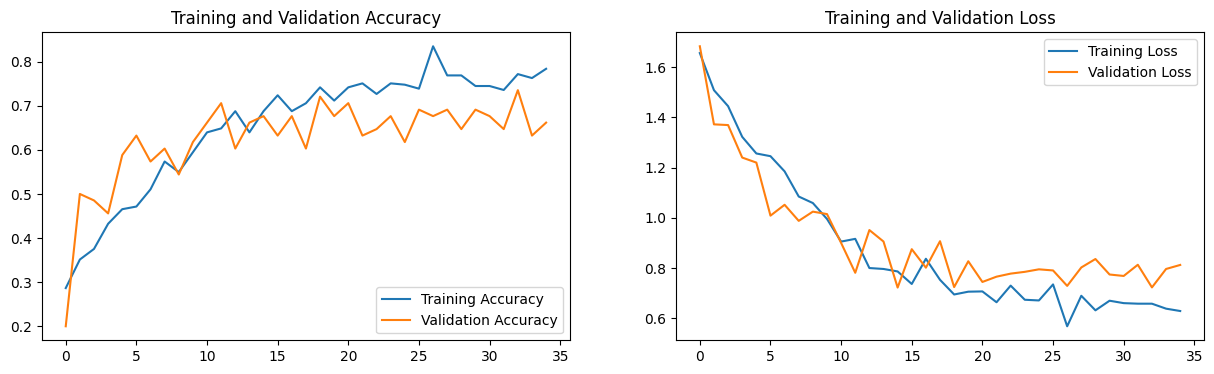

In [70]:
plot_model(model_plot)

##  Finally, We considered Model 6 as we got the better results for both Train(86%) and Test Set(80%) with a minimal loss values at Epoch 30. 

# Conv2D + RNN models using both LSTM and GRU 

# MODEL 9

### Used LSTM layer on Model 6 with Conv2D 

In [71]:
total_frames = 30
num_frames = 10
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [72]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))
optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 50, 50, 8)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 25, 25, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 25, 25, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 12, 12, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 12, 12, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 6, 6, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 6, 6, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 3, 3, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 10, 576)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,109 (754.33 KB)

 Trainable params: 193,109 (754.33 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [74]:

model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [75]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [76]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - categorical_accuracy: 0.2207 - loss: 1.6901Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60482, saving model to model_exp7_2024-04-0811_35_06.450272/model-00001-1.67836-0.22474-1.60482-0.26000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 446ms/step - categorical_accuracy: 0.2207 - loss: 1.6900 - val_categorical_accuracy: 0.2600 - val_loss: 1.6048 - learning_rate: 2.0000e-04
Epoch 2/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - categorical_accuracy: 0.2113 - loss: 1.6208
Epoch 2: val_loss did not improve from 1.60482
166/166 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step - categorical_accuracy: 0.2113 - loss: 1.6209 - val_categorical_accuracy: 0.2100 - val_loss: 1.6077 - learning_rate: 2.0000e-04
Epoch 3/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - categorical_accuracy: 0.2404 - loss: 1.6062
Epoch 3: va

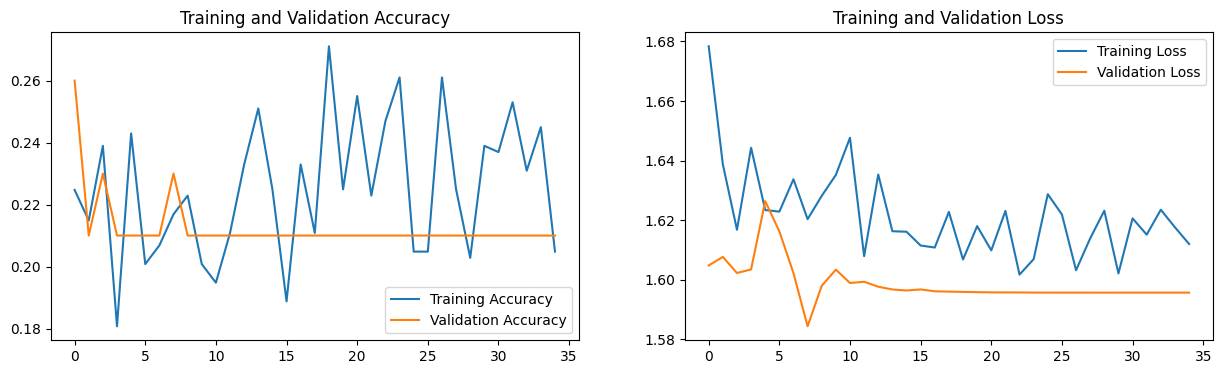

In [77]:
plot_model(model_plot)

# MODEL 10

### Used GRU layer on Model 6 with Conv2D 

In [78]:
total_frames = 30
num_frames = 10
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [79]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))
optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ (None, 10, 50, 50, 8)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 25, 25, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 25, 25, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 10, 12, 12, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 10, 12, 12, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 10, 6, 6, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 10, 6, 6, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 10, 3, 3, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 10, 576)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │       123,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,277 (594.83 KB)

 Trainable params: 152,277 (594.83 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [81]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [82]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [83]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - categorical_accuracy: 0.2270 - loss: 1.7737Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60763, saving model to model_exp8_2024-04-0811_35_06.450272/model-00001-1.73194-0.22775-1.60763-0.23000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 83s 468ms/step - categorical_accuracy: 0.2270 - loss: 1.7735 - val_categorical_accuracy: 0.2300 - val_loss: 1.6076 - learning_rate: 2.0000e-04
Epoch 2/35
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - categorical_accuracy: 0.2076 - loss: 1.6756
Epoch 2: val_loss improved from 1.60763 to 1.59712, saving model to model_exp8_2024-04-0811_35_06.450272/model-00002-1.66946-0.22490-1.59712-0.21000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - categorical_accuracy: 0.2077 - loss: 1.6756 - val_categorical_accuracy: 0.2100 - val_loss: 1.5971 - learning_rate: 2.0000e-04


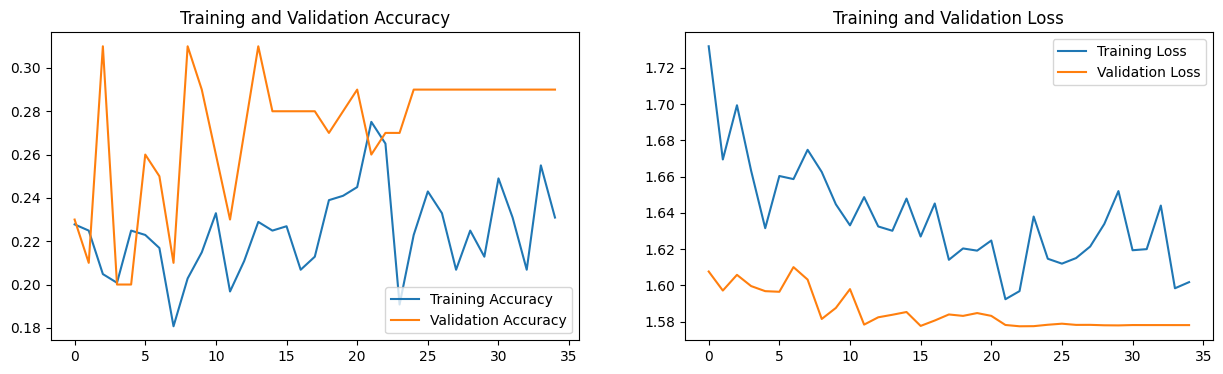

In [84]:
plot_model(model_plot)

# MODEL 11

### Used LSTM layer on Model 7 with Conv2D 

In [107]:
total_frames = 30
num_frames = 12  
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4  

num_epochs=25

In [108]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))
optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_36             │ (None, 12, 50, 50, 8)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 12, 25, 25, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 12, 25, 25, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 12, 12, 12, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 12, 12, 12, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 12, 6, 6, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 12, 6, 6, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 12, 3, 3, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 12, 576)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,109 (754.33 KB)

 Trainable params: 193,109 (754.33 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [110]:
model_name = 'model_exp9__' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [111]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [112]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - categorical_accuracy: 0.1733 - loss: 1.7329Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.60284, saving model to model_exp9__2024-04-0811_35_06.450272/model-00001-1.69048-0.19005-1.60284-0.23000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 89s 504ms/step - categorical_accuracy: 0.1734 - loss: 1.7327 - val_categorical_accuracy: 0.2300 - val_loss: 1.6028 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - categorical_accuracy: 0.2311 - loss: 1.6488
Epoch 2: val_loss did not improve from 1.60284
166/166 ━━━━━━━━━━━━━━━━━━━━ 63s 381ms/step - categorical_accuracy: 0.2309 - loss: 1.6488 - val_categorical_accuracy: 0.2300 - val_loss: 1.6046 - learning_rate: 2.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - categorical_accuracy: 0.1855 - loss: 1.6609
Epoch 3: v

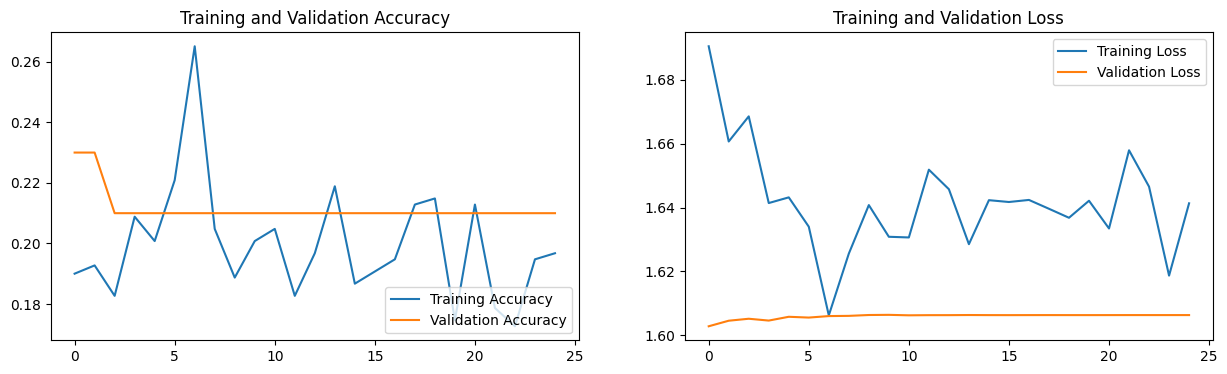

In [113]:
plot_model(model_plot)

# MODEL 12

### Used GRU layer on Model 7 with Conv2D 

In [100]:
total_frames = 30
num_frames = 12  
classes = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4  

num_epochs=25

In [101]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(img_idx), image_height, image_width, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))
optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_27             │ (None, 12, 50, 50, 8)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 12, 25, 25, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 12, 25, 25, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 12, 12, 12, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 12, 12, 12, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 12, 6, 6, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 12, 6, 6, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 12, 3, 3, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 12, 576)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │       123,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,277 (594.83 KB)

 Trainable params: 152,277 (594.83 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [103]:
model_name = 'model_exp10_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [104]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [105]:
model_plot = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path =  /kaggle/input/dataset/Project_data/train ; batch size = 4
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - categorical_accuracy: 0.1781 - loss: 1.7661Source path =  /kaggle/input/dataset/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.61585, saving model to model_exp10_2024-04-0811_35_06.450272/model-00001-1.70776-0.19306-1.61585-0.17000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 98s 558ms/step - categorical_accuracy: 0.1782 - loss: 1.7657 - val_categorical_accuracy: 0.1700 - val_loss: 1.6158 - learning_rate: 2.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - categorical_accuracy: 0.1921 - loss: 1.6504
Epoch 2: val_loss improved from 1.61585 to 1.60058, saving model to model_exp10_2024-04-0811_35_06.450272/model-00002-1.63552-0.22088-1.60058-0.25000.h5.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 61s 370ms/step - categorical_accuracy: 0.1923 - loss: 1.6503 - val_categorical_accuracy: 0.2500 - val_loss: 1.6006 - learning_rate: 2.0000e-0

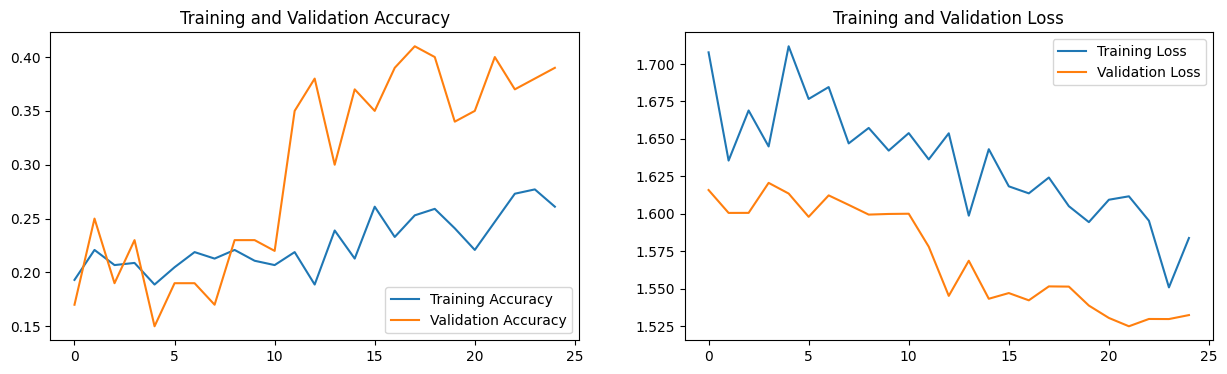

In [106]:
plot_model(model_plot)

# Conv 2D not performing as good as Conv3D. So we are proceeding with Conv3D as the final model.

## 1st Best Model: Final Model
### This is to check the total no.of parameters present in the best model (Model 6)
#### Epoch: 30 : loss: 0.408, Train acc:0.863, Val_loss: 0.631, Test acc: 0.800

In [114]:
# Load models to check the architecture one last time
from tensorflow.keras.models import load_model

In [117]:
model = load_model('/kaggle/working/model_exp6_2024-04-0811_35_06.450272/model-00030-0.40803-0.86345-0.63196-0.80000.h5')
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_18 (Conv3D)              │ (None, 10, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 10, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 5, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 5, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 5, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 5, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 2, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_20 (Conv3D)              │ (None, 2, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 2, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 2, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,487 (376.91 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 2 (12.00 B)

# This is the Second best Model (Model 6)

#### Epoch: 26: loss: 0.466, Train acc:0.837, Val_loss: 0.662, Test acc: 0.820

In [118]:
model = load_model('/kaggle/working/model_exp6_2024-04-0811_35_06.450272/model-00026-0.46660-0.83735-0.66291-0.82000.h5')
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_18 (Conv3D)              │ (None, 10, 50, 50, 8)  │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 10, 50, 50, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 5, 25, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 5, 25, 25, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 5, 25, 25, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 5, 25, 25, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 2, 12, 12, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_20 (Conv3D)              │ (None, 2, 12, 12, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 2, 12, 12, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 2, 12, 12, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 1, 6, 6, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,487 (376.91 KB)

 Trainable params: 96,373 (376.46 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 2 (12.00 B)